In [1]:
import pickle

import pandas as pd

from copy import deepcopy

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [40]:
with open('../data/interim/02_cleaned.pkl', 'rb') as picklefile:
    df_listings = pickle.load(picklefile)

In [41]:
with open('../data/interim/05_nmf_topics.pkl', 'rb') as picklefile:
    df_topics = pickle.load(picklefile)

In [42]:
df_topics = df_topics[['neighborhood', 'city', 'topic']]

In [43]:
df_listings = df_listings.merge(df_topics, how='left', on=['neighborhood', 'city'])

In [44]:
df_listings = df_listings.dropna().reset_index(drop=True)

#### Create dummy variables

In [45]:
cat_columns = ['host_is_superhost', 'host_response_time', 'cancellation_policy', 'room_type']

In [46]:
df_dummies = df_listings[['neighborhood', 'city', 'reviews_per_month', 'topic', 'bathrooms', 'property_type']]

In [47]:
df_dummies.loc[df_dummies['bathrooms'] <= 1, 'bathrooms'] = 0
df_dummies.loc[df_dummies['bathrooms'] > 1, 'bathrooms'] = 1
df_dummies.rename(columns={'bathrooms': 'multiple_bathrooms'}, inplace=True)

In [48]:
conventional = ['Apartment', 'House', 'Condominium', 'Loft', 'Townhouse']
professional = ['Bed & Breakfast', 'Hostel', 'Boutique Hotel']

In [49]:
df_dummies.loc[:, 'property_cat'] = df_dummies['property_type'].apply(lambda x: 'conventional' if x in conventional else ('professional' if x in professional else 'quirky'))
df_temp = pd.get_dummies(df_dummies['property_cat'], drop_first=False)
df_dummies = df_dummies.merge(df_temp, left_index=True, right_index=True)
df_dummies.drop(['property_type', 'property_cat'], axis=1, inplace=True)

In [50]:
df_dummies.head()

,neighborhood,city,reviews_per_month,topic,multiple_bathrooms,conventional,professional,quirky
0,Brentwood,austin,0.17,easy car access,0.0,1.0,0.0,0.0
1,Brentwood,austin,0.56,easy car access,0.0,1.0,0.0,0.0
2,Brentwood,austin,0.55,easy car access,0.0,1.0,0.0,0.0
3,Brentwood,austin,0.02,easy car access,0.0,1.0,0.0,0.0
4,Brentwood,austin,4.84,easy car access,0.0,1.0,0.0,0.0


In [51]:
for column in cat_columns:
    df_temp = pd.get_dummies(df_listings[column], drop_first=False, prefix=column)
    df_dummies = df_dummies.merge(df_temp, left_index=True, right_index=True)

In [52]:
df_dummies.head()

,neighborhood,city,reviews_per_month,topic,multiple_bathrooms,conventional,professional,quirky,host_is_superhost_f,host_is_superhost_t,...,host_response_time_within an hour,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_no_refunds,cancellation_policy_strict,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,Brentwood,austin,0.17,easy car access,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Brentwood,austin,0.56,easy car access,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,Brentwood,austin,0.55,easy car access,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,Brentwood,austin,0.02,easy car access,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,Brentwood,austin,4.84,easy car access,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


#### Add numerical features

In [53]:
numerical_columns = ['price_person', 'review_scores_rating']

In [54]:
df_num = df_listings[numerical_columns]

#### Merge dataframes

In [55]:
df_model = df_dummies.merge(df_num, left_index=True, right_index=True)

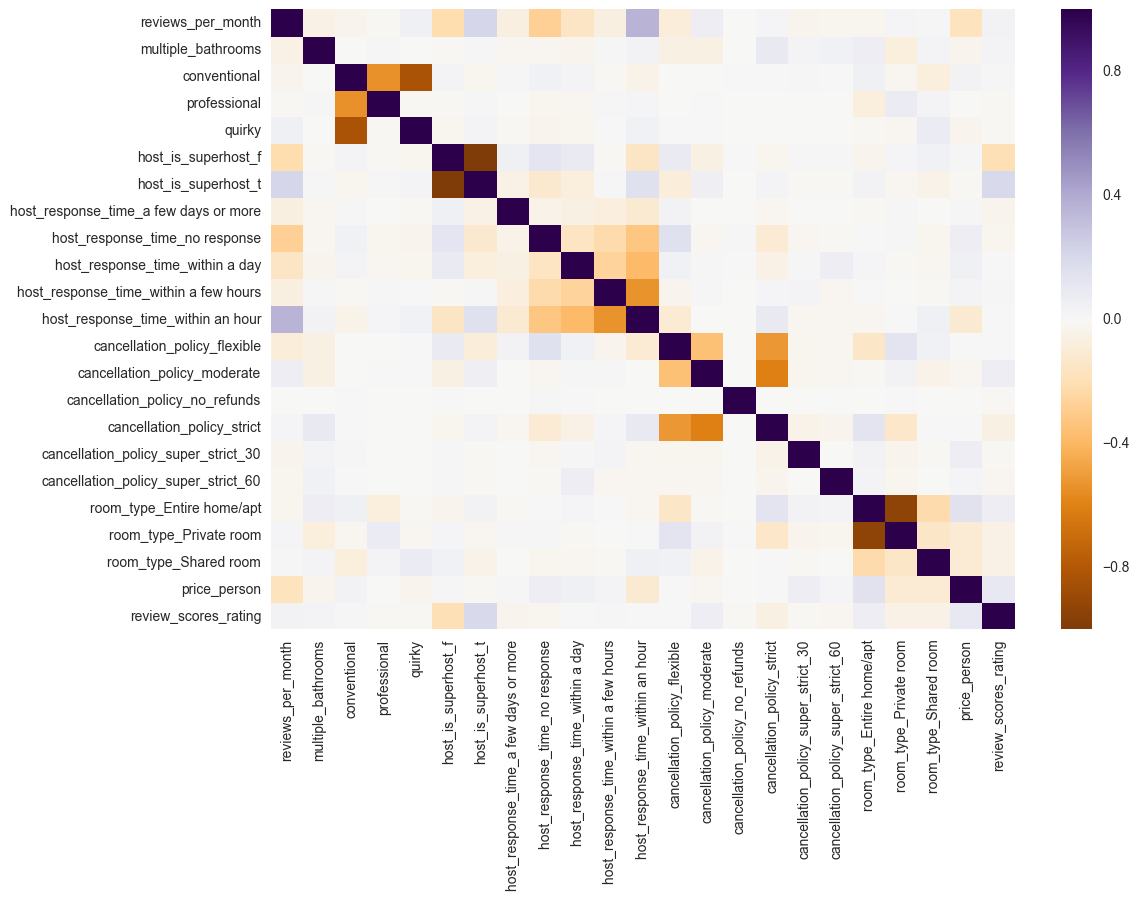

In [56]:
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(df_model.corr(), ax=ax, cmap="PuOr");

In [57]:
X = df_model.drop(['neighborhood', 'city', 'topic'], axis=1)
y = X.pop('reviews_per_month')

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=16)

In [59]:
rf = RandomForestRegressor(n_estimators=500, max_depth=6)

In [60]:
rf.fit(X_train, y_train)
rf.score(X_train, y_train)

0.28441902754596593

In [61]:
rf.score(X_test, y_test)

0.27527854911648131

In [62]:
features = X.columns.tolist()
importances = rf.feature_importances_.tolist()
zip(features, importances)

[('multiple_bathrooms', 0.006552494528602003),
 ('conventional', 0.0005024766144267262),
 ('professional', 0.0005534521784431277),
 ('quirky', 0.0015944326572266384),
 ('host_is_superhost_f', 0.022975646339027992),
 ('host_is_superhost_t', 0.031099658013763957),
 ('host_response_time_a few days or more', 6.830414372714251e-05),
 ('host_response_time_no response', 0.10065741214110253),
 ('host_response_time_within a day', 0.00019541855583128846),
 ('host_response_time_within a few hours', 0.01039090712658585),
 ('host_response_time_within an hour', 0.46964893569734584),
 ('cancellation_policy_flexible', 0.000580872180457673),
 ('cancellation_policy_moderate', 0.002047615244988139),
 ('cancellation_policy_no_refunds', 0.0),
 ('cancellation_policy_strict', 0.0031130923317147516),
 ('cancellation_policy_super_strict_30', 4.647496604213392e-06),
 ('cancellation_policy_super_strict_60', 1.2245863972085406e-06),
 ('room_type_Entire home/apt', 0.001016497128574524),
 ('room_type_Private room',

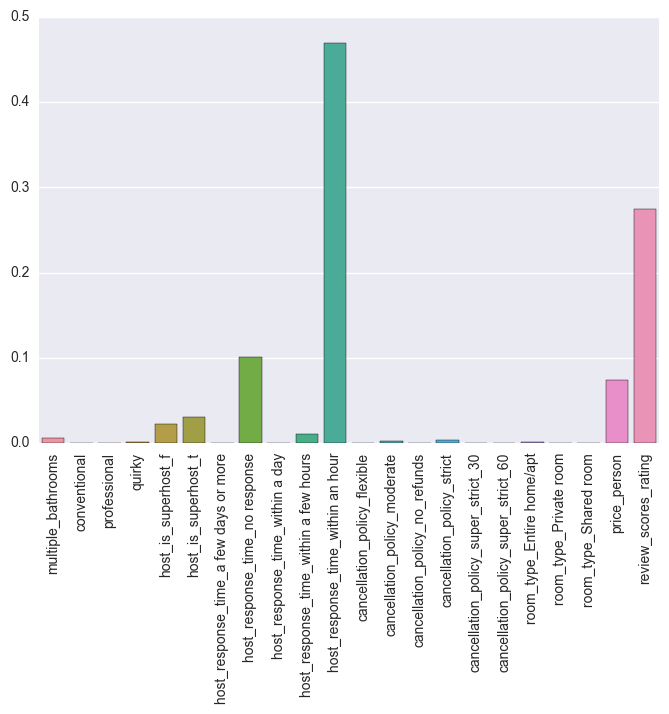

In [63]:
fig = sns.barplot(features, importances)
plt.xticks(rotation=90);

### Hyperlocal models

In [64]:
clusters = df_model['topic'].unique().tolist()
clusters.sort()

In [65]:
#keep features to plot coefficients across clusters
from collections import defaultdict
feat_imps = dict.fromkeys(features)
for key in feat_imps.keys():
    feat_imps[key] = []

In [66]:
from sklearn.metrics import mean_squared_error
import numpy as np

In [67]:
def plot_hyperlocals(cluster):
    X_temp = df_model[df_model['topic'] == cluster].drop(['neighborhood', 'city', 'topic'], axis=1)
    y_temp = X_temp.pop('reviews_per_month')
    X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=0.3, random_state=16)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_test)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    title = 'Cluster ' + str(cluster) + ', # listings: ' + str(len(y_temp)) + ', RMSE: ' + str(score)
    
    #score = rf.score(X_test, y_test)
    #title = 'Cluster ' + str(cluster) + ', # listings: ' + str(len(y_temp)) + ', r^2: ' + str(score)
    
    features = X_temp.columns.tolist()
    importances = rf.feature_importances_.tolist()
    
    for feature, importance in zip(features, importances):
        feat_imps[feature].append(importance)

    fig, ax = plt.subplots()
    fig = sns.barplot(features, importances)
    ax.set_ybound(lower=0, upper=0.5)
    fig.axes.set_title(title)
    plt.xticks(rotation=90);

In [68]:
y.describe()

count    44434.000000
mean         1.788555
std          1.747077
min          0.010000
25%          0.470000
50%          1.180000
75%          2.610000
max         19.150000
Name: reviews_per_month, dtype: float64

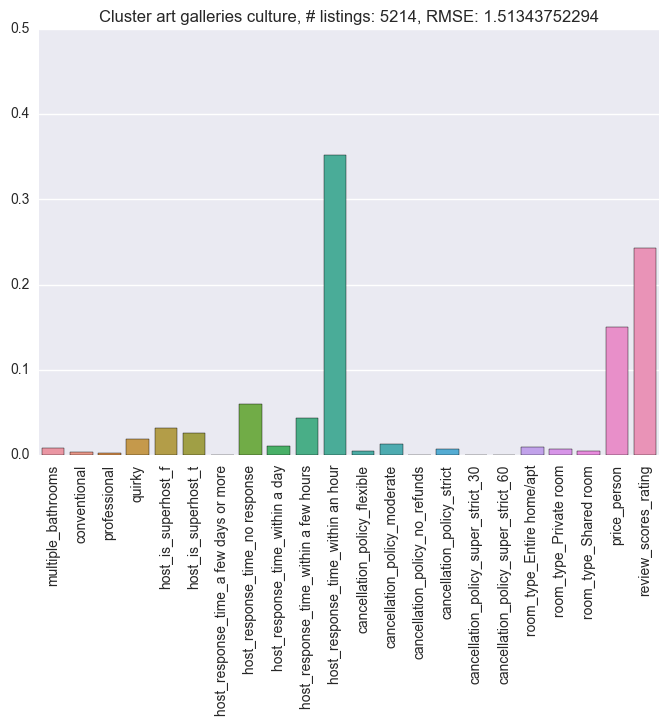

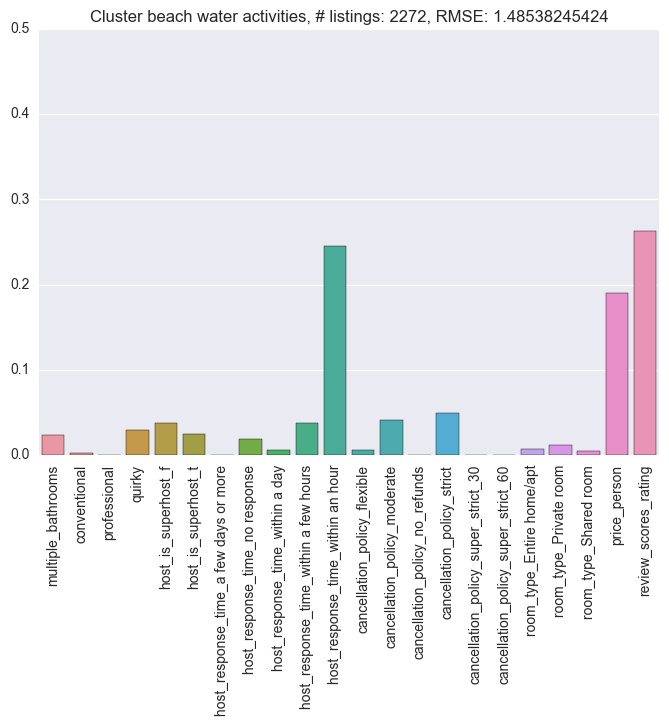

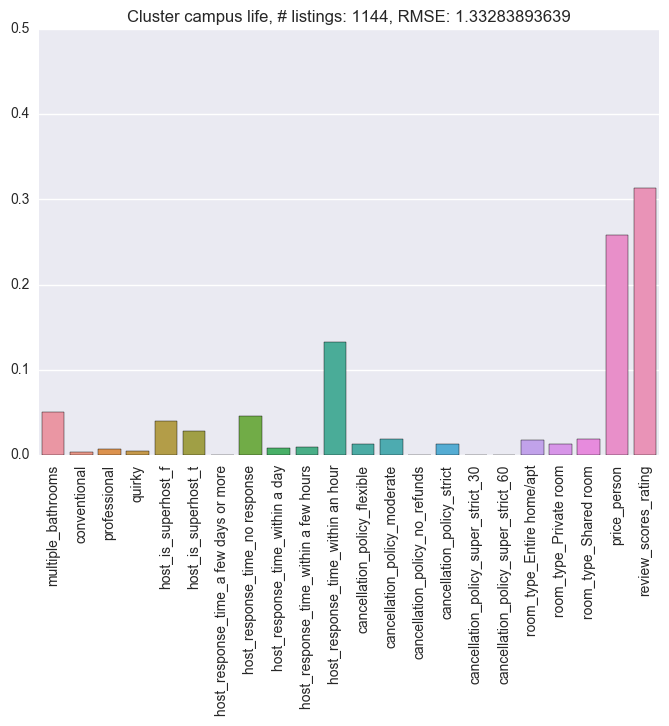

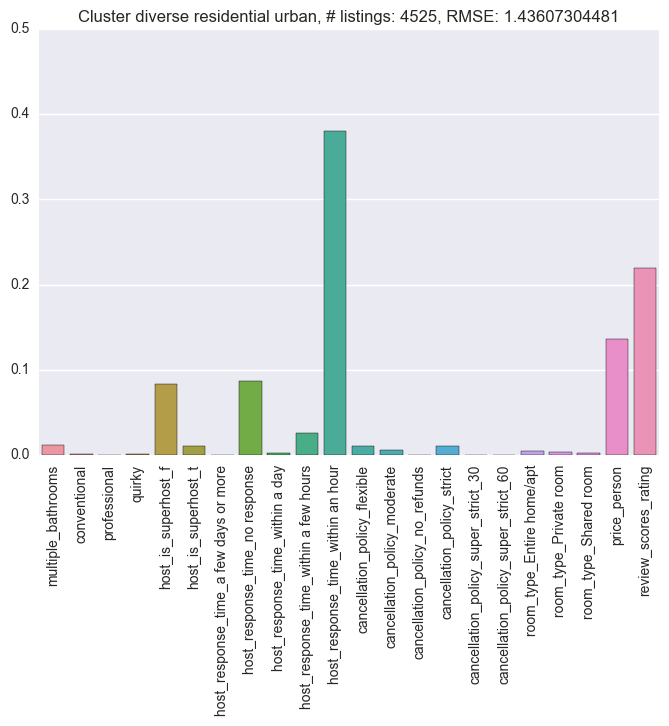

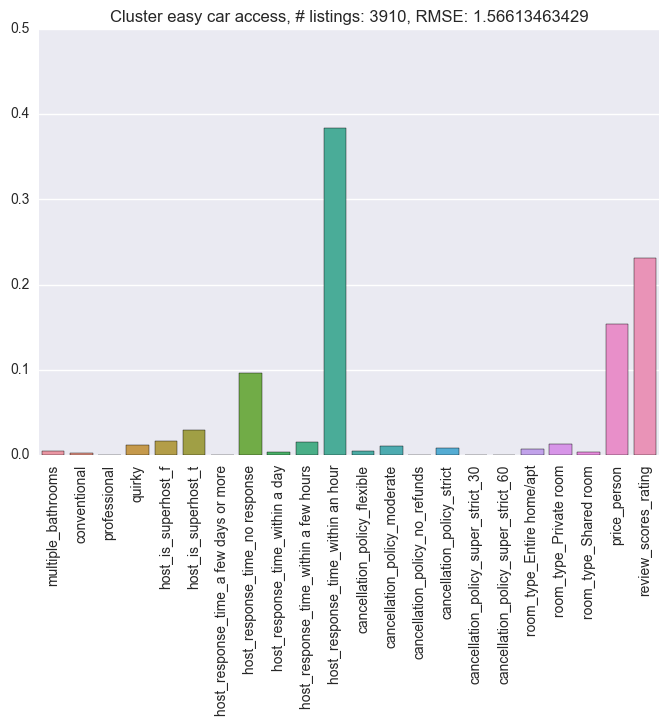

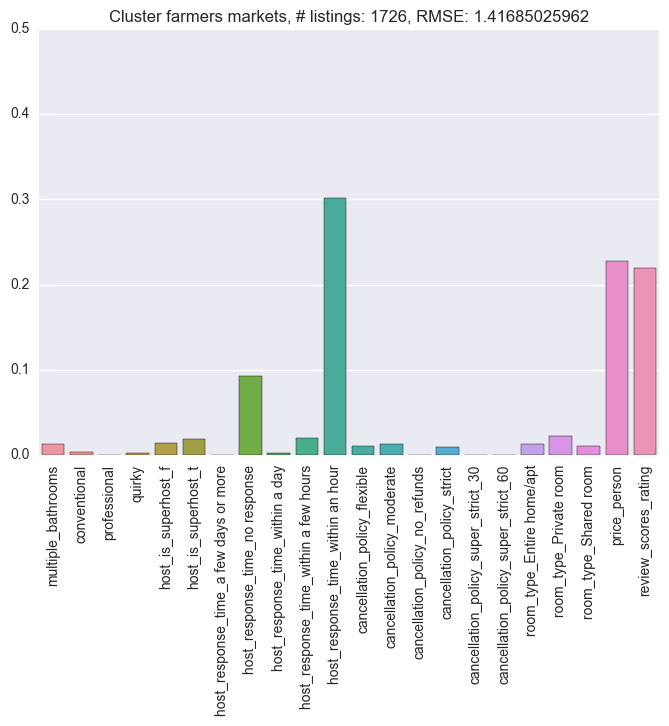

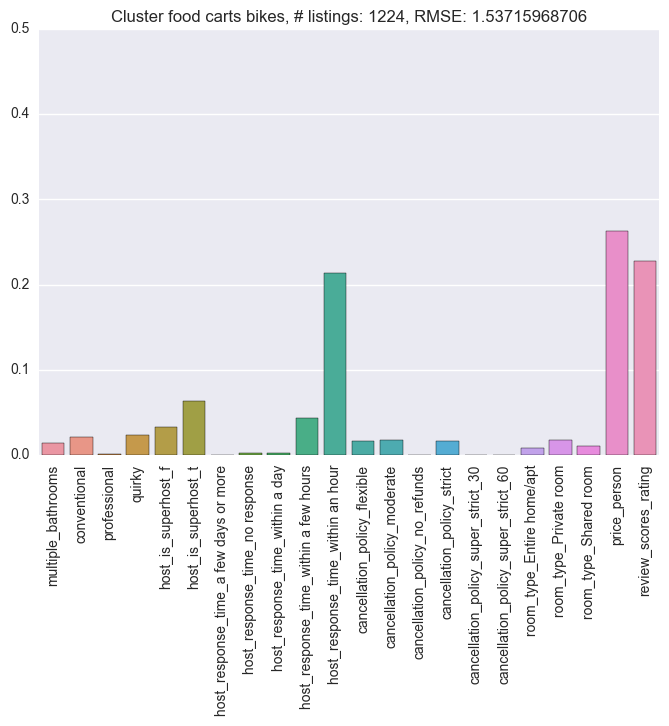

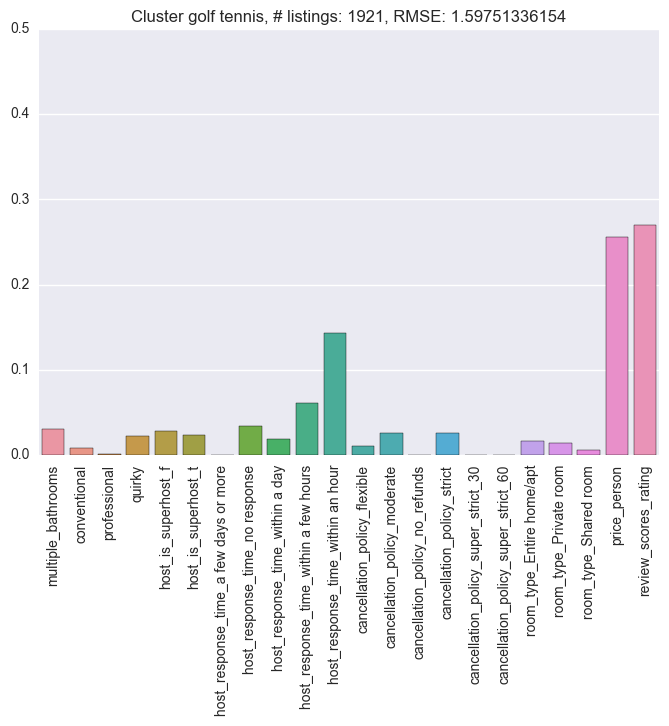

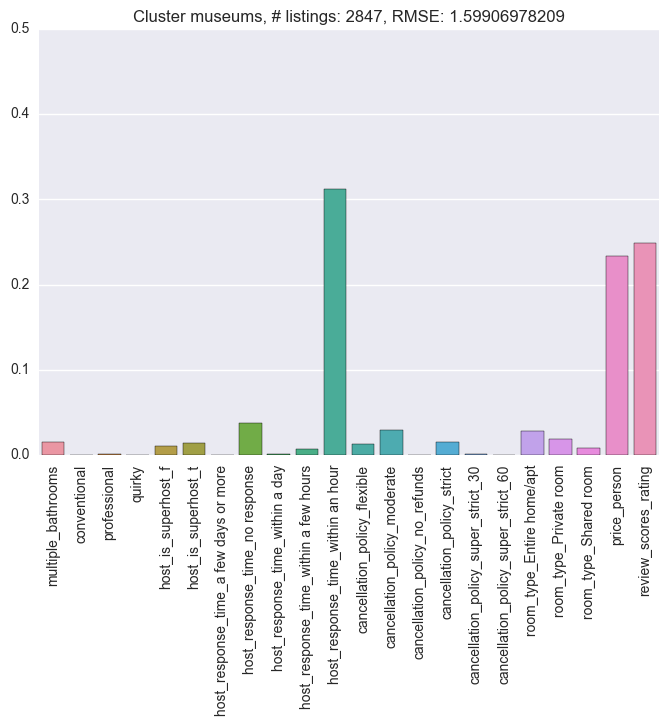

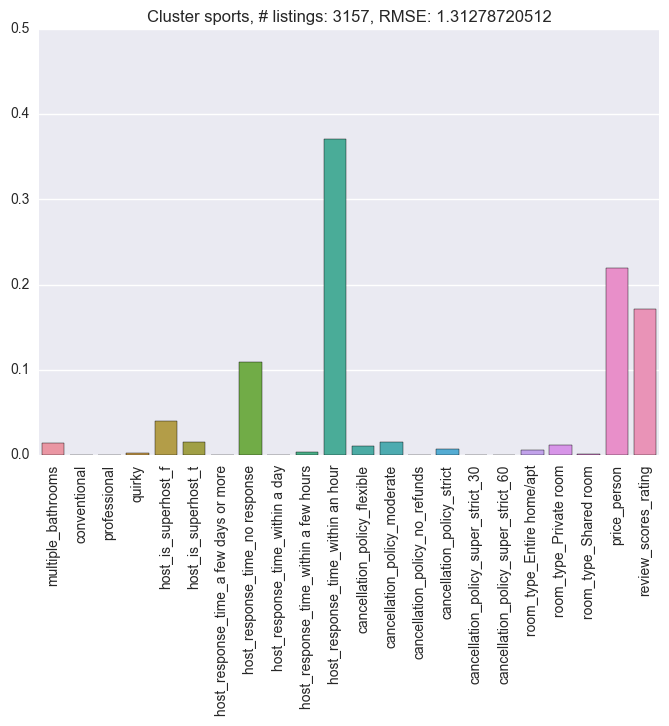

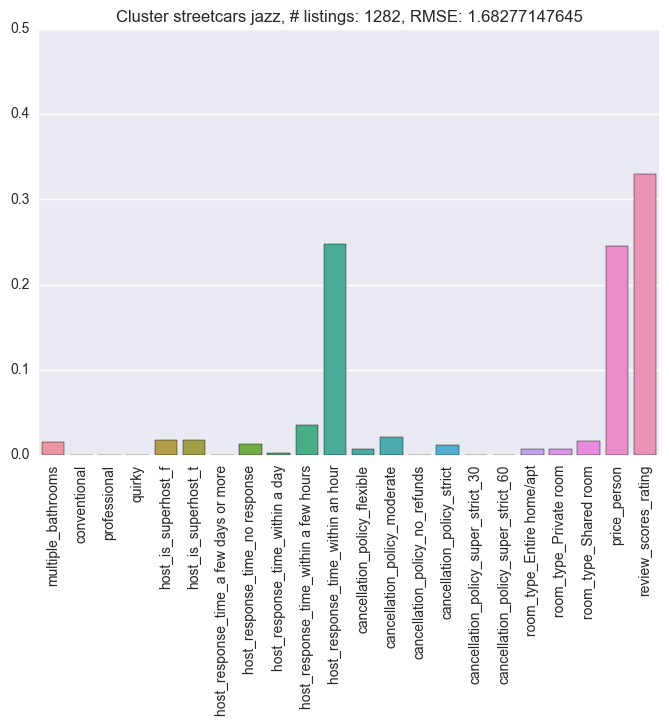

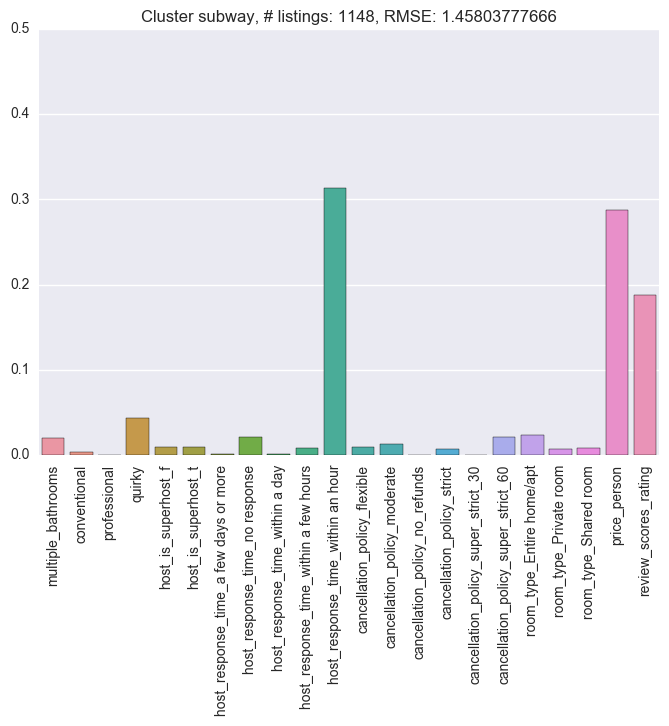

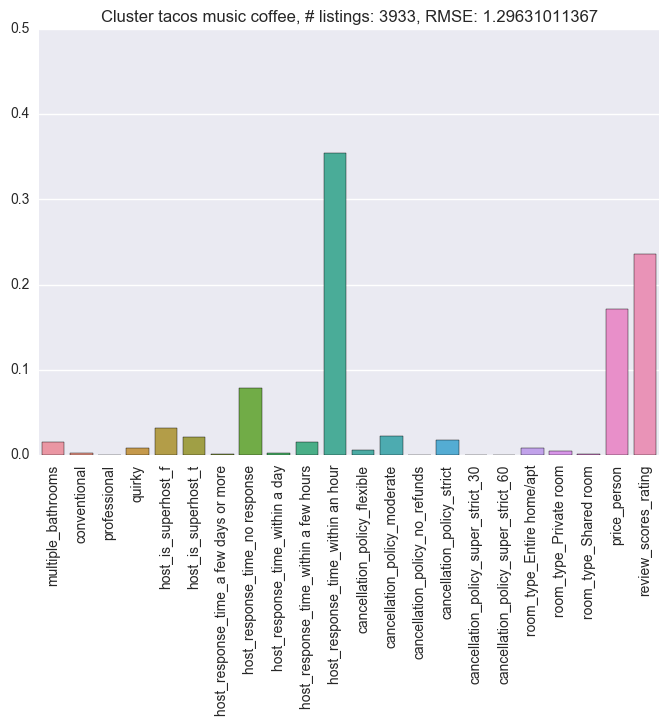

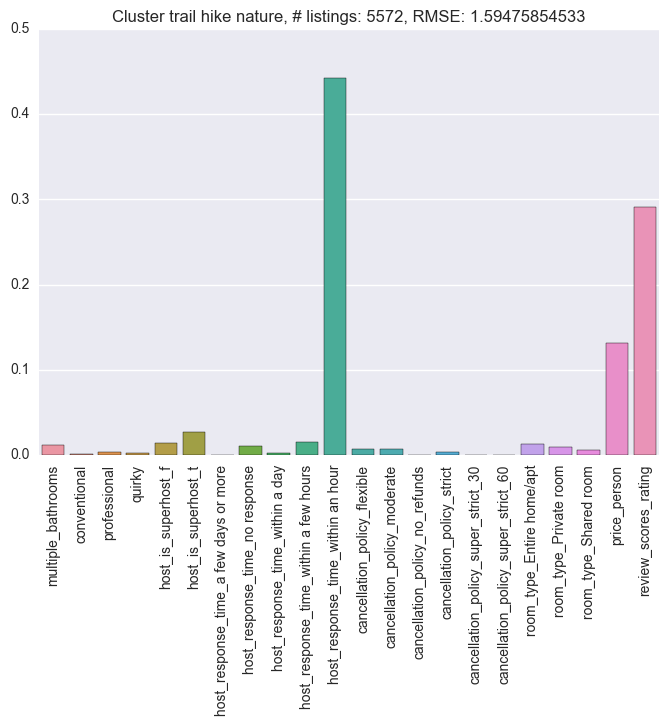

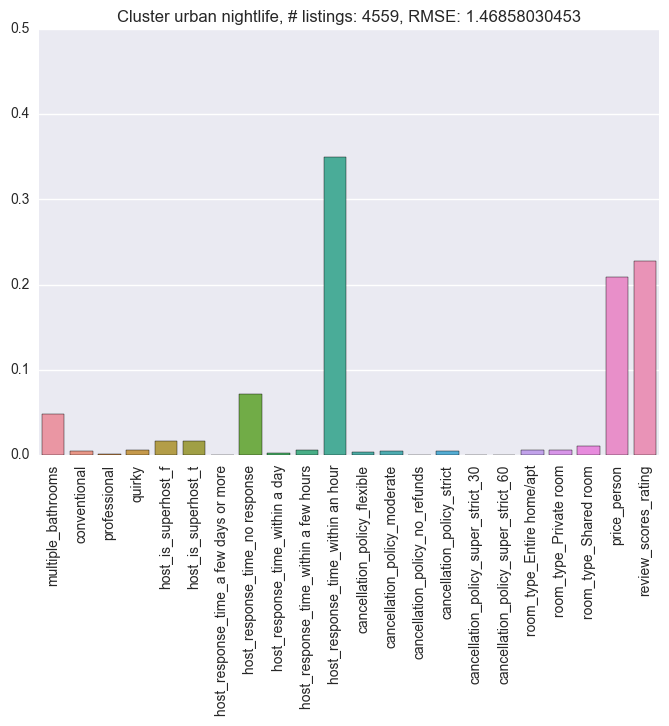

In [69]:
for cluster in clusters:
    plot_hyperlocals(cluster)

In [71]:
def plot_coefficients(dct, key):
    #clusters = range(0,16)
    feat_imps = dct[key]    
    fig, ax = plt.subplots()
    fig = sns.barplot(clusters, feat_imps)
    #ax.set_ybound(lower=0, upper=0.5)
    fig.axes.set_title(key)
    plt.xticks(rotation=90);

In [72]:
feat_imps['cancellation_policy_moderate']

[0.013534060131406234,
 0.041456072465731034,
 0.019250514986102675,
 0.006411030496504501,
 0.010755272190069779,
 0.012793990173321251,
 0.018268645559027557,
 0.026017750481889142,
 0.029915976231463172,
 0.015162243263389403,
 0.02153703534284453,
 0.013461380485775885,
 0.02294681070534295,
 0.007674200272156533,
 0.005066570423023573]

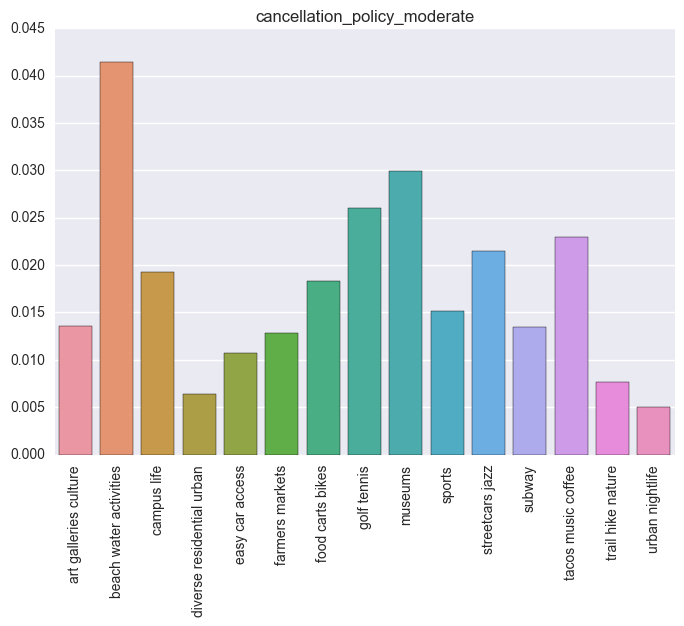

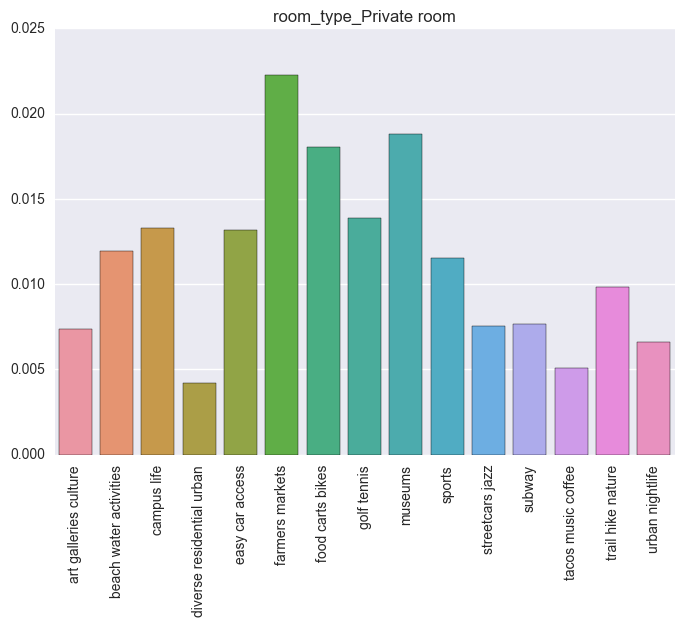

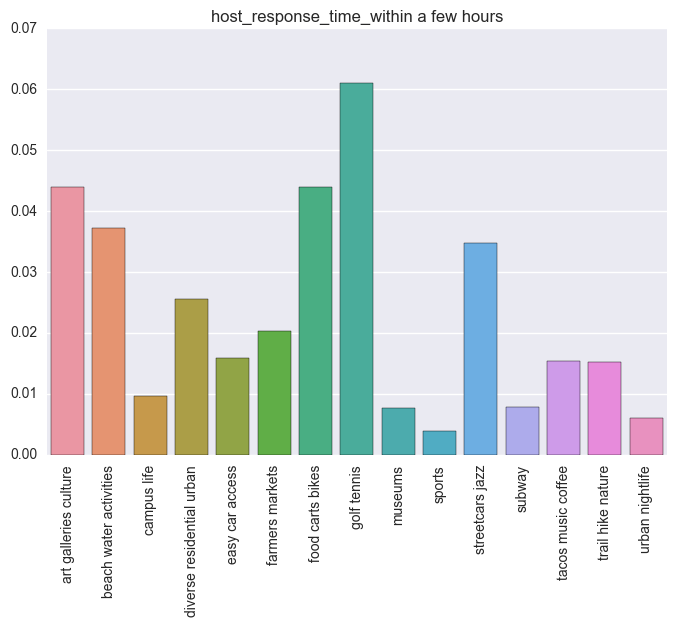

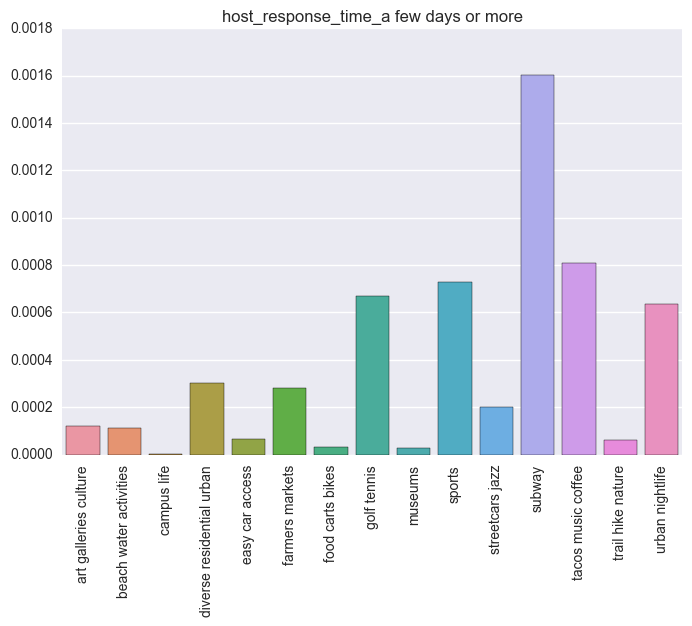

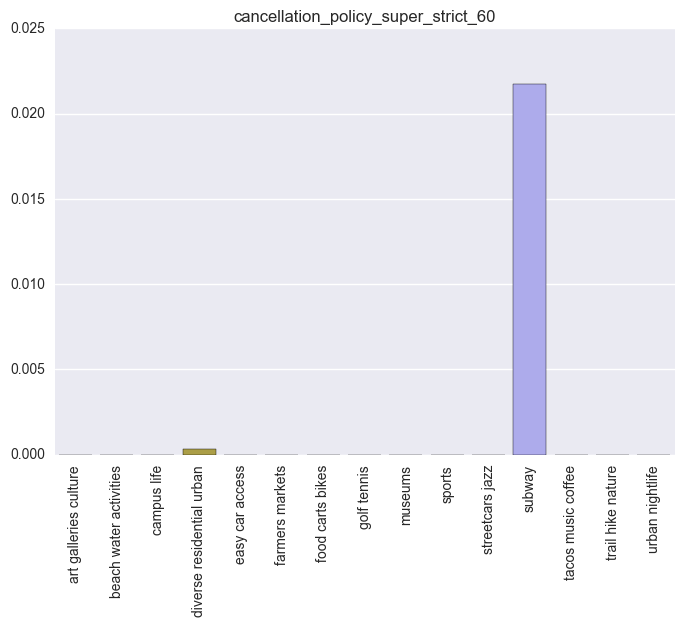

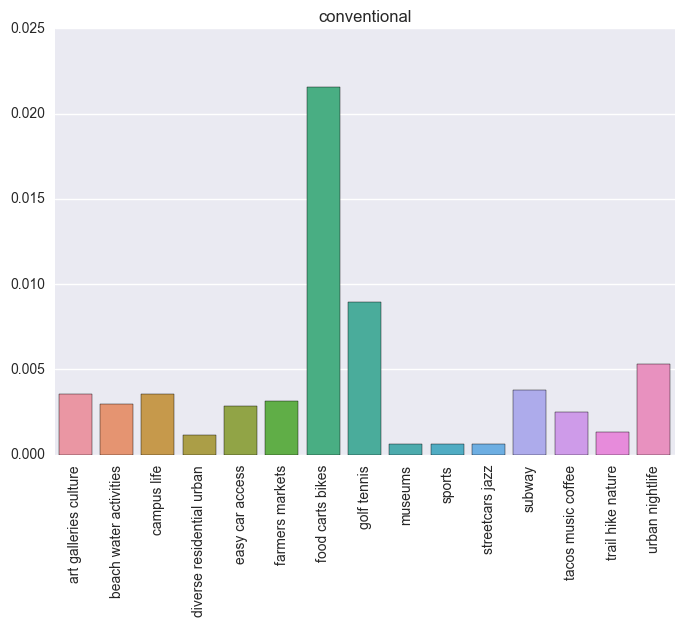

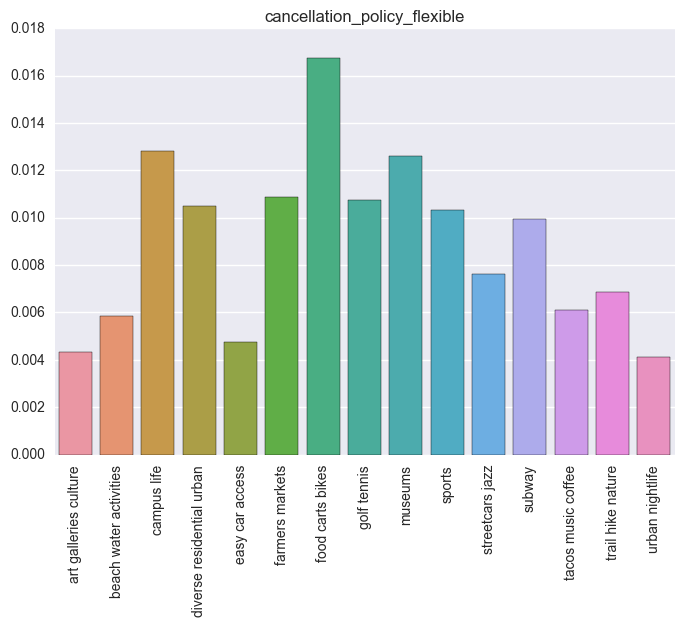

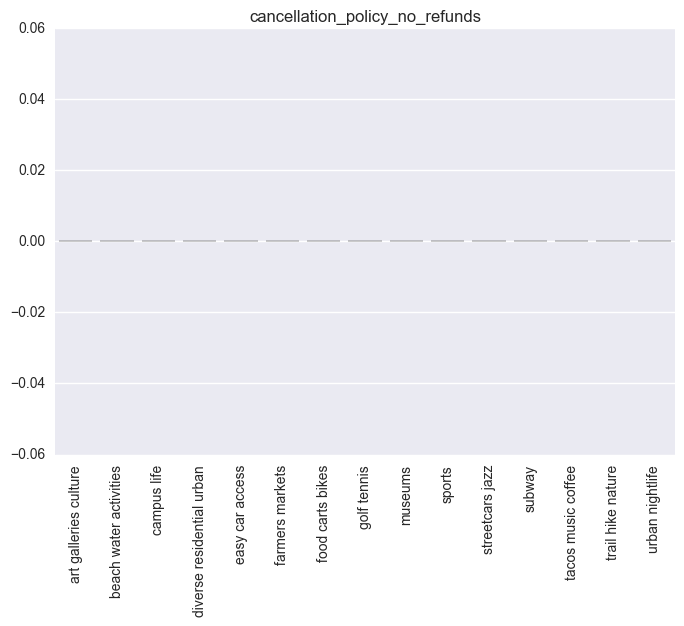

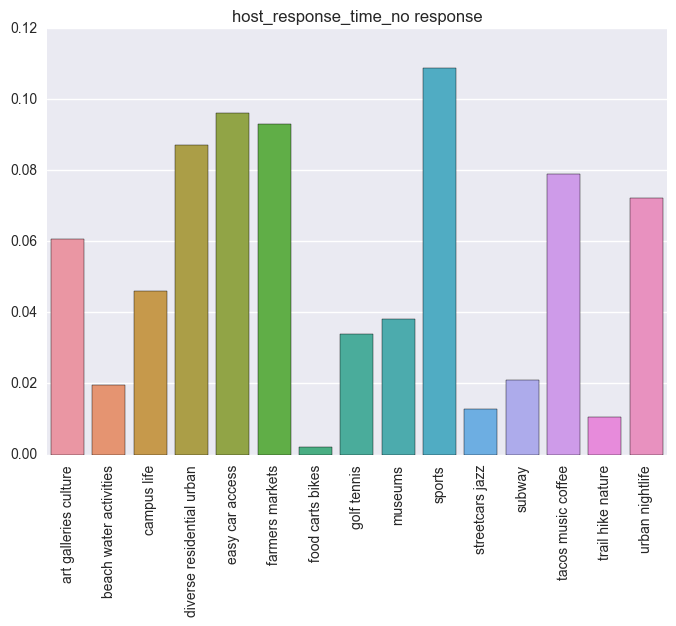

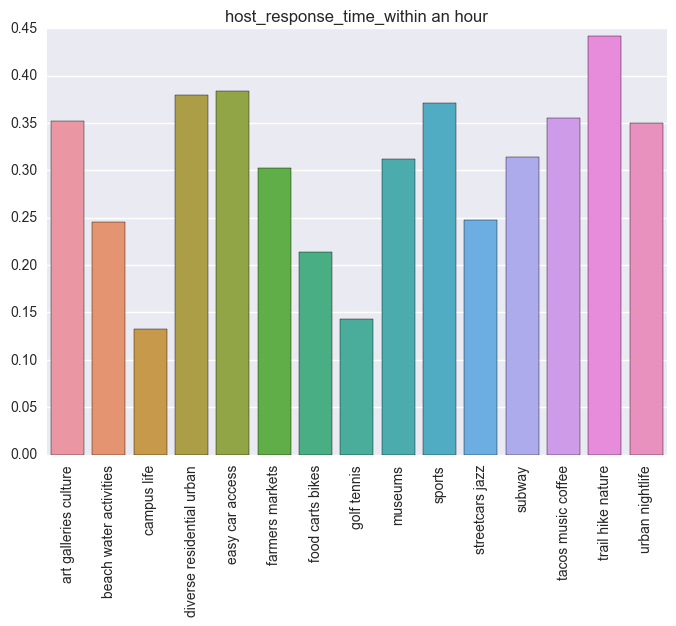

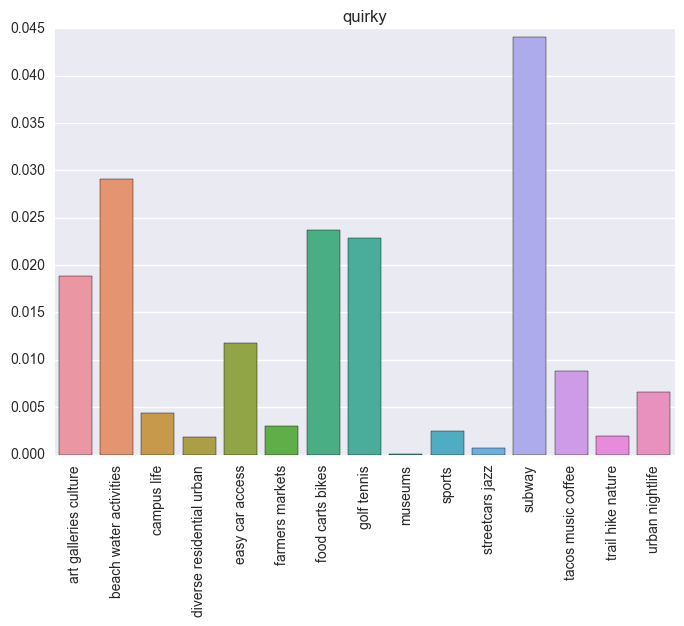

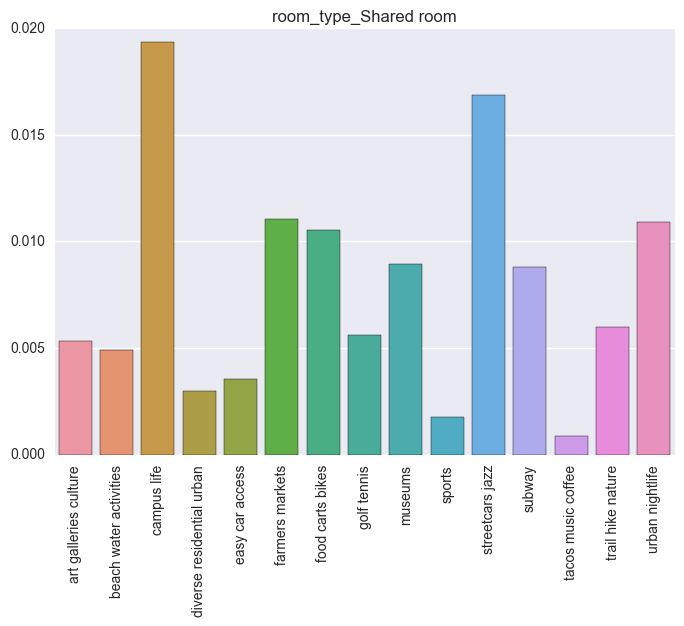

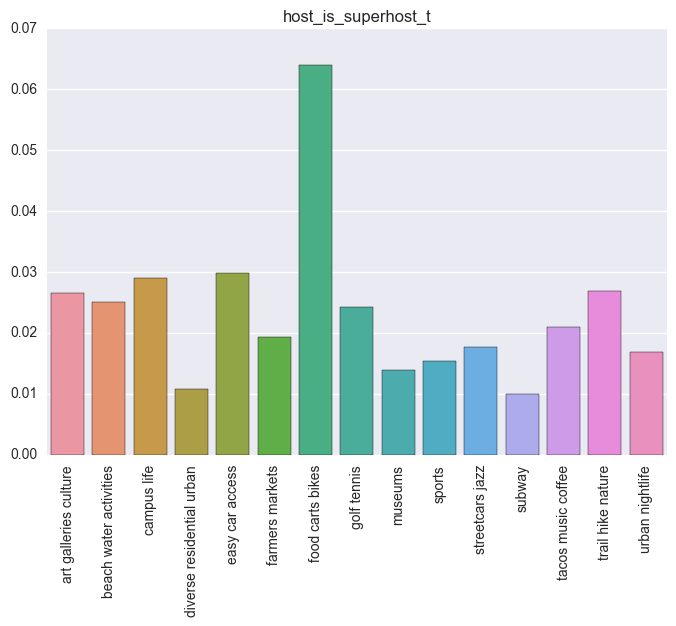

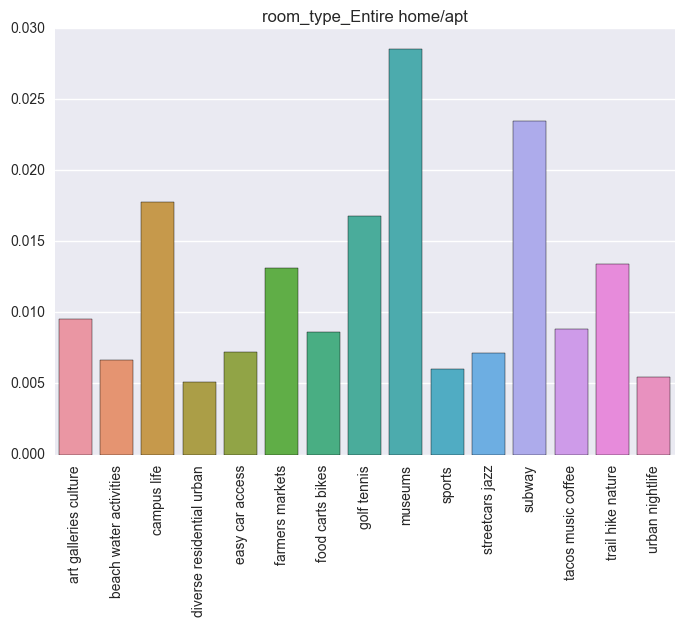

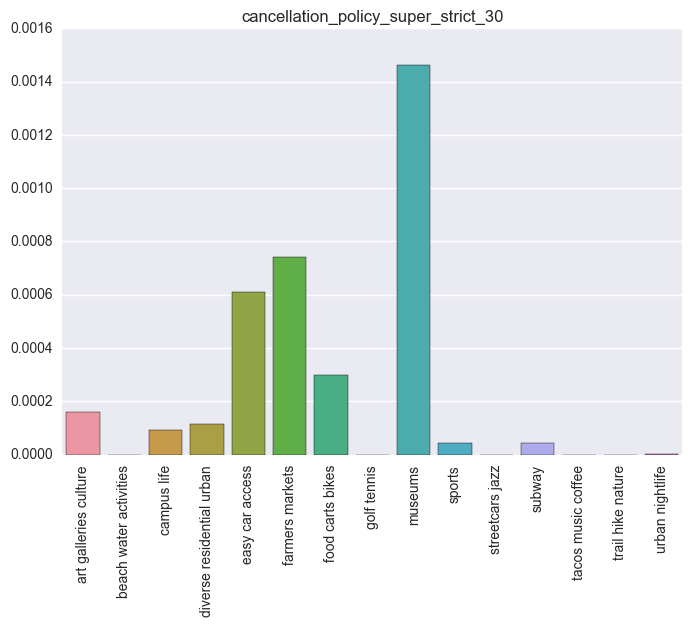

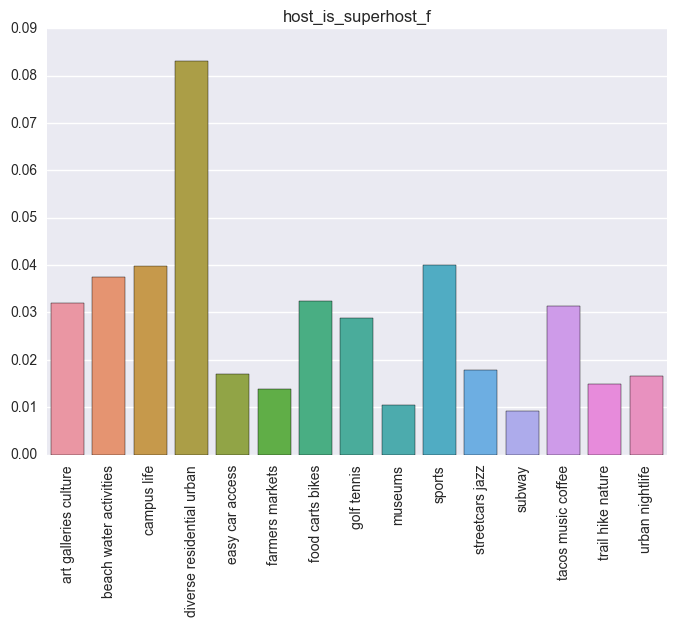

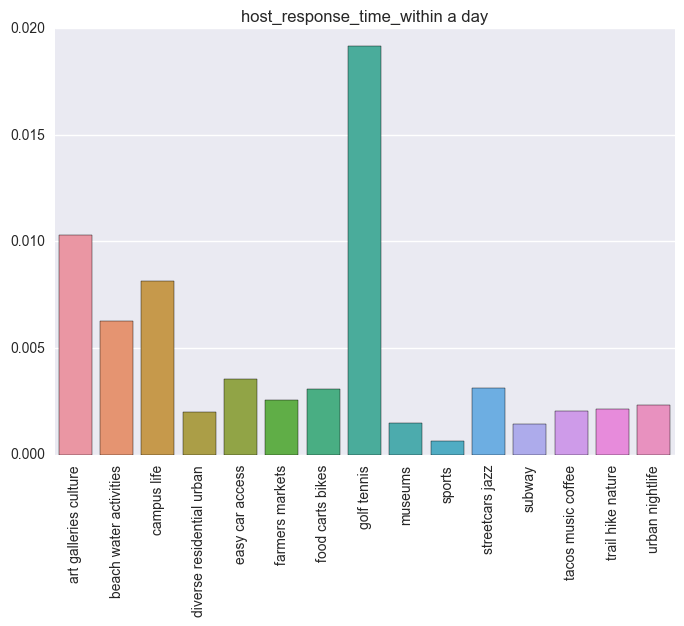

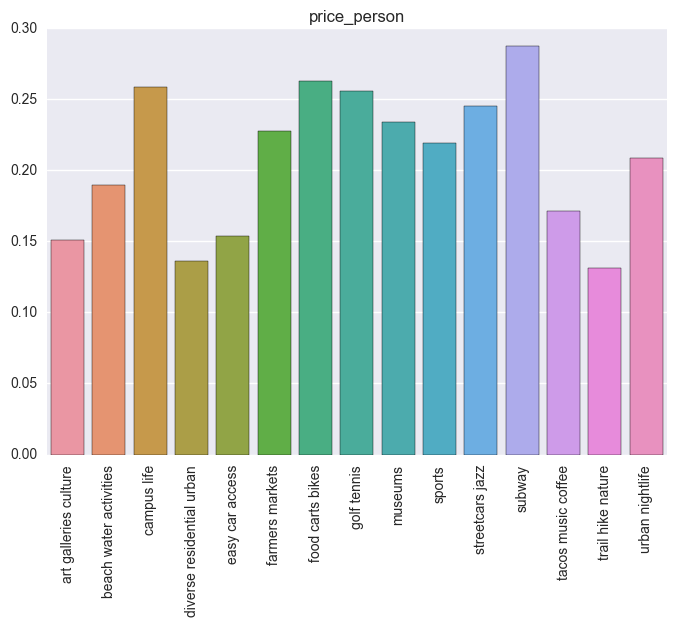

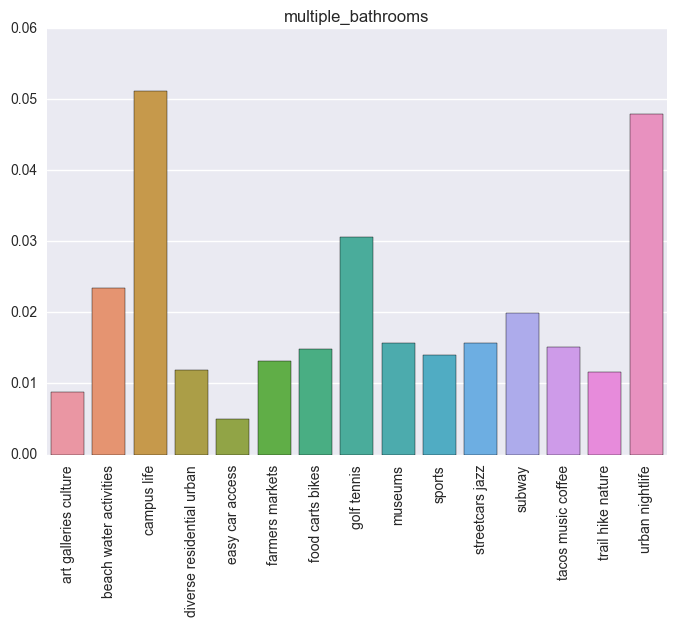

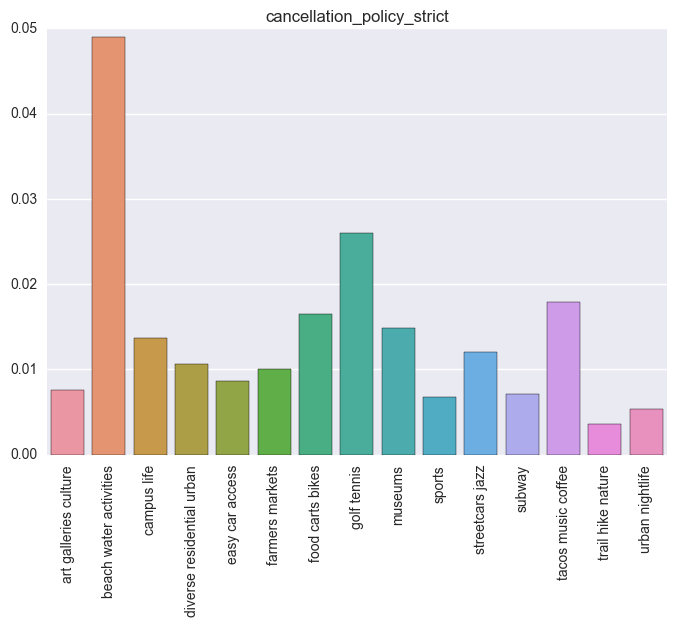

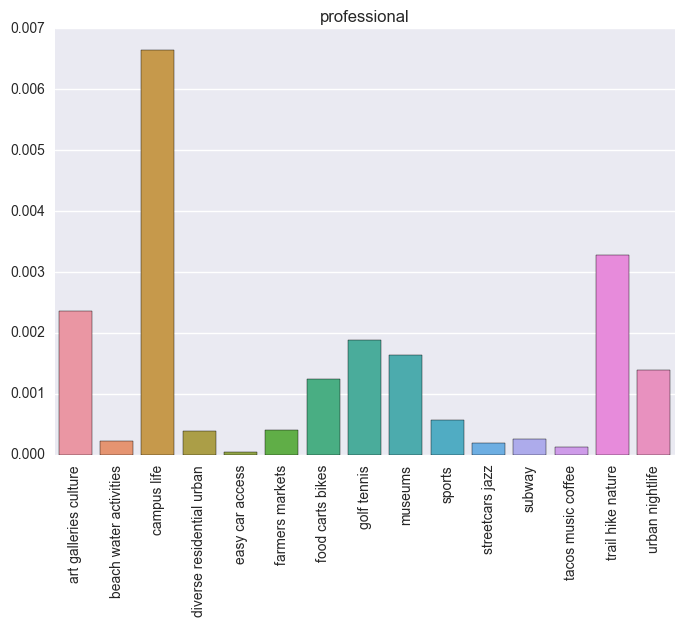

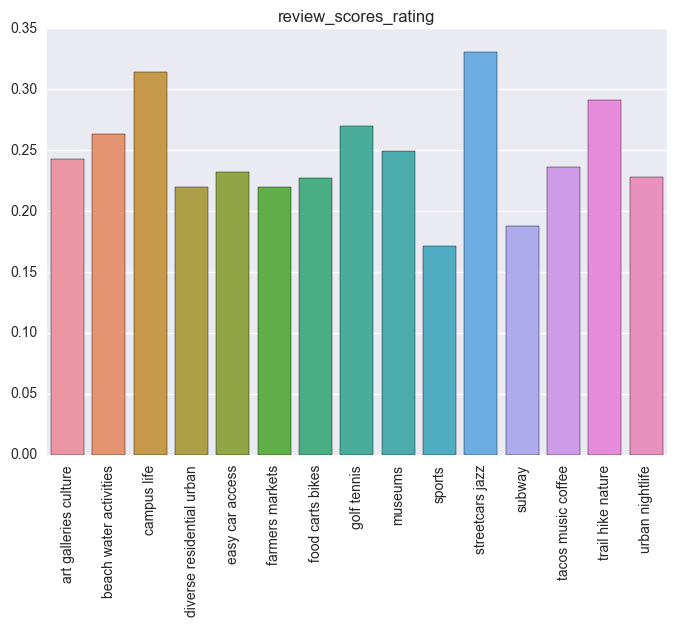

In [73]:
for feature in feat_imps.keys():
    plot_coefficients(feat_imps, feature)